In [1]:
import numpy as np
import copy
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, Aer, execute, BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

from qiskit.primitives import Estimator, BackendEstimator

pi = np.pi

In [2]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [3]:
type_chart = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0, 1],
                  [1, 0.5, 0.5, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0.5, 1, 0.5], 
                  [1, 2, 0.5, 1, 0.5, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0.5], 
                  [1, 1, 2, 0.5, 0.5, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0.5], 
                  [1, 0.5, 2, 1, 0.5, 1, 1, 0.5, 2, 0.5, 1, 0.5, 2, 1, 0.5], 
                  [1, 1, 0.5, 1, 2, 0.5, 1, 1, 2, 2, 1, 1, 1, 1, 2], 
                  [2, 1, 1, 1, 1, 2, 1, 0.5, 1, 0.5, 0.5, 0.5, 2, 0, 1], 
                  [1, 1, 1, 1, 2, 1, 1, 0.5, 0.5, 1, 1, 2, 0.5, 0.5, 1], 
                  [1, 2, 1, 2, 0.5, 1, 1, 2, 1, 0, 1, 0.5, 2, 1, 1], 
                  [1, 1, 1, 0.5, 2, 1, 2, 1, 1, 1, 1, 2, 0.5, 1, 1], 
                  [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0.5, 1, 1, 1, 1], 
                  [1, 0.5, 1, 1, 2, 1, 0.5, 2, 1, 0.5, 2, 1, 1, 0.5, 1], 
                  [1, 2, 1, 1, 1, 2, 0.5, 1, 0.5, 2, 1, 2, 1, 1, 1], 
                  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1], 
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]])

n = len(type_chart)

In [4]:
attack = []
for i in range(n):
    attack.append([0 if j < 2 else 1 for j in type_chart[i]])
attacknp = np.array(attack)

In [5]:
defence = []
for i in range(n):
    defence.append([1 if (j == 0.5 or j == 0) else 0 for j in type_chart[i]])
defencenp = (np.array(defence)).T

In [71]:
mdl = Model("docplex model")

all_types = ["normal", "fire", "water", "electric", "grass", "ice", "fighting", "poison", "ground", "flying", "psychic", "bug", "rock", "ghost", "dragon"]

pokemon_types = np.array([mdl.binary_var(i) for i in all_types]).T

In [72]:
weights = [0 for i in range(n)]

for i in range(n):
    attack_score = sum([(-1 if type_chart[i][j] == 2 else 1 if type_chart[i][j] == 0.5 else 2 if type_chart[i][j] == 0 else 0) for j in range(n)])
    defence_score = sum([(-1 if (type_chart.T)[i][j] == 2 else 1 if (type_chart.T)[i][j] == 0.5 else 2 if (type_chart.T)[i][j] == 0 else 0) for j in range(n)])
    weights[i] = (attack_score - defence_score)
    
print(weights)

[2, 1, -1, 2, 4, 0, 3, 2, -1, -3, -4, 2, -2, -2, -3]


In [73]:
mdl.minimize(
    np.dot(np.array(weights), pokemon_types) + \
    sum(np.dot(attacknp, pokemon_types)) - \
    sum(np.dot(defencenp, pokemon_types))
)

mdl.add_constraint(6 == sum(pokemon_types), "total_number")

# mdl.add_constraint(sum(np.dot(attacknp, pokemon_types)) <= 12, f"attack")

# for i in range(n):
#     mdl.add_constraint(np.dot(attacknp[i], pokemon_types) <= 2, f"attack_{all_types[i]}")

# for i in range(n):
#     mdl.add_constraint(np.dot(defencenp[i], pokemon_types) >= 1, f"defence_{all_types[i]}")

# mdl.remove_constraint("attack_normal")

docplex.mp.LinearConstraint[total_number](normal+fire+water+electric+grass+ice+fighting+poison+ground+flying+psychic+bug+rock+ghost+dragon,EQ,6)

In [74]:
qp_mdl = from_docplex_mp(mdl)
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp_mdl)

qp = relax_problem(qubo)
print(qp.prettyprint())

Problem name: docplex model

Minimize
  23*bug^2 + 46*bug*dragon + 46*bug*ghost + 46*bug*rock + 23*dragon^2
  + 46*electric*bug + 46*electric*dragon + 23*electric^2 + 46*electric*fighting
  + 46*electric*flying + 46*electric*ghost + 46*electric*grass
  + 46*electric*ground + 46*electric*ice + 46*electric*poison
  + 46*electric*psychic + 46*electric*rock + 46*fighting*bug
  + 46*fighting*dragon + 23*fighting^2 + 46*fighting*flying + 46*fighting*ghost
  + 46*fighting*ground + 46*fighting*poison + 46*fighting*psychic
  + 46*fighting*rock + 46*fire*bug + 46*fire*dragon + 46*fire*electric
  + 46*fire*fighting + 23*fire^2 + 46*fire*flying + 46*fire*ghost
  + 46*fire*grass + 46*fire*ground + 46*fire*ice + 46*fire*poison
  + 46*fire*psychic + 46*fire*rock + 46*fire*water + 46*flying*bug
  + 46*flying*dragon + 23*flying^2 + 46*flying*ghost + 46*flying*psychic
  + 46*flying*rock + 46*ghost*dragon + 23*ghost^2 + 46*grass*bug
  + 46*grass*dragon + 46*grass*fighting + 46*grass*flying + 46*grass*gho

In [75]:
sol = CplexOptimizer().solve(qp)
c_stars = sol.samples[0].x
print(c_stars)

[0, 9.732121432422281e-08, 1.0, 1.0, 2.4330279913542623e-08, 0, 0, 4.8660592443712006e-08, 1.0, 0.999999902679156, 0.9999999675596662, 3.2440369240636243e-08, 0, 0.999999951339538, 0.02173910498774001]


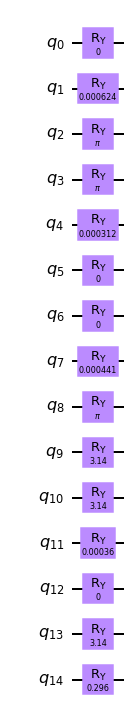

In [76]:
thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(n)
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

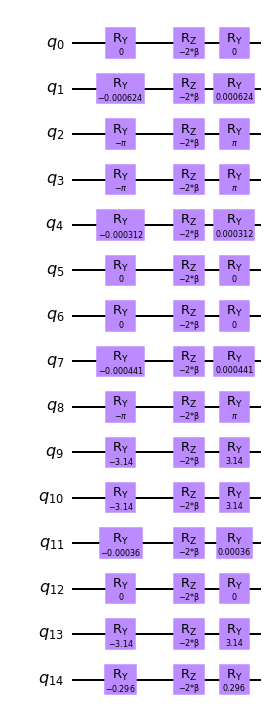

In [77]:
beta = Parameter("β")

ws_mixer = QuantumCircuit(n)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

In [78]:
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

In [79]:
ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
)

ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

ws_qaoa_result = ws_qaoa.solve(qp_mdl)
print(ws_qaoa_result.prettyprint())

result = CplexOptimizer().solve(qubo)
print(result.prettyprint())

objective function value: -13.0
variable values: normal=0.0, fire=0.0, water=1.0, electric=1.0, grass=0.0, ice=0.0, fighting=0.0, poison=0.0, ground=1.0, flying=1.0, psychic=1.0, bug=0.0, rock=0.0, ghost=1.0, dragon=0.0
status: SUCCESS
objective function value: -13.0
variable values: normal=0.0, fire=0.0, water=1.0, electric=1.0, grass=0.0, ice=0.0, fighting=0.0, poison=0.0, ground=1.0, flying=1.0, psychic=1.0, bug=0.0, rock=0.0, ghost=1.0, dragon=0.0
status: SUCCESS
